# Scaffold Split in Hyperparameter Tuning
*Contributed by Ruel Cedeno @cedenoruel*


By default, scikit-learn performs **random split** in cross-validation and hyperparameter tuning.

This could result in highly optimistic model performance especially if the compounds in the test set have similar analogs in the training set (some would consider it as *data leakage*).

To truly assess the model's generalizability on unseen molecular architectures, **scaffold split** is generally recommended. 

In this notebook, you will learn:
- How to use scaffold splits in generating test sets, performing cross validations and hyperparameter tuning
- Advantages of using scaffold splits 

In [35]:
# import the usual suspects
import os
import rdkit
from rdkit import Chem
import pandas as pd
import matplotlib.pyplot as plt
from time import time
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split


#from scikit_mol package

from scikit_mol.fingerprints import MorganFingerprintTransformer

#added feature
from scikit_mol.splitter import get_scaffold_groups, train_test_group_split, GroupSplitCV

#to maintain reproducibility
random_state= 41 


## Step 1: Import dataset 
We will use the same dataset (SLC6A4) as in the previous tutorials.

In [3]:
csv_file = "../tests/data/SLC6A4_active_excapedb_subset.csv"
data = pd.read_csv(csv_file)

#Add ROMol column to the dataframe
data["ROMol"] = data.SMILES.apply(Chem.MolFromSmiles)

## Step 2: Standardize molecules

One key advantage of scikit-mol is it allows you to save/pickle models that **work directly on rdkit Mol object**.

This solves the problem of having to generate features/descriptors externally with the risk of being incompatible with the saved model (that you may have built few months ago).  

In [5]:
# Probably the recommended way would be to prestandardize the data if there's no changes to the transformer,
# and then add the standardizer in the inference pipeline.

from scikit_mol.standardizer import Standardizer

standardizer = Standardizer()

data["ROMol"] = standardizer.transform(data["ROMol"]).flatten()

In [6]:
data

,Ambit_InchiKey,SMILES,pXC50,ROMol
0,RBCQCVSMIQCOMN-PCQZLOAONA-N,C12C([C@@H](OC(C=3C=CC(=CC3)F)C=4C=CC(=CC4)F)C...,6.26000,<rdkit.Chem.rdchem.Mol object at 0x7fe95a8d3ae0>
1,ALZTYVXVRZIERJ-UHFFFAOYNA-N,O(C1=NC=C2C(CN(CC2=C1)C)C3=CC=C(OC)C=C3)CCCN(C...,7.18046,<rdkit.Chem.rdchem.Mol object at 0x7fe95a8d3a70>
2,MOEMPBAHOJKXBG-MRXNPFEDNA-N,O=S(=O)(N(CC=1C=CC2=CC=CC=C2C1)[C@@H]3CCNC3)C,7.77000,<rdkit.Chem.rdchem.Mol object at 0x7fe95a8d3a00>
3,HEKGBDCRHYILPL-QWOVJGMINA-N,C1(=C2C(CCCC2O)=NC=3C1=CC=CC3)NCC=4C=CC(=CC4)Cl,5.24000,<rdkit.Chem.rdchem.Mol object at 0x7fe95a8d3d10>
4,SNNRWIBSGBMYRF-UKRRQHHQNA-N,C1NC[C@@H](C1)[C@H](OC=2C=CC(=NC2C)OC)CC(C)C,9.12000,<rdkit.Chem.rdchem.Mol object at 0x7fe95a8d3990>
...,...,...,...,...
195,PIKWEFAACQLYMF-UHFFFAOYNA-N,C1=CC=C2C=CC(=CC2=C1)C(N3N=NC(=N3)C=4C=CC=CC4)...,6.60000,<rdkit.Chem.rdchem.Mol object at 0x7fe959ba2b20>
196,AUZWJAMWJZUPHQ-UHFFFAOYNA-N,C(OC1=CC=C(C=C1)Cl)(C=2C=CC(=CC2)F)C3CNCCC3,7.86000,<rdkit.Chem.rdchem.Mol object at 0x7fe959ba2b90>
197,JCEWQICHOLLRDL-WUFINQPMNA-N,O(C1=CC=2[C@@H]3N(C[C@H](C2C=C1)C4=CC=C(N5N=CC...,8.22185,<rdkit.Chem.rdchem.Mol object at 0x7fe959ba2c00>
198,NGRIUVQYFBDXMT-JYAVWHMHNA-N,C1NC[C@@H]2[C@H]1[C@@]2(CCOCC)C3=CC(=C(C=C3)Cl)Cl,9.30000,<rdkit.Chem.rdchem.Mol object at 0x7fe959ba2c70>


## Step 3: Use scaffold split to obtain train and test sets

In a conventional random split, you would use the following 
```python
X_train, X_test, y_train, y_test = train_test_split(X = data.ROMol, y = data.pXC50, test_size=0.2)
```
To perform a scaffold split, simply  use ```get_scaffold_groups``` to add a column containing the **scaffold ID**  then pass it to the parameter ```groups``` in the ```train_test_group_slit```  

In [7]:
data["scaffold_ID"] = get_scaffold_groups(data["ROMol"])

X_train, X_test, y_train, y_test = train_test_group_split(X = data.ROMol, y = data.pXC50, groups = data.scaffold_ID, test_size=0.2)



To verify whether the test set does not contain any scaffold in the training set:

In [36]:

X_train_scaffold = X_train.apply(Chem.Scaffolds.MurckoScaffold.GetScaffoldForMol).apply(Chem.MolToSmiles)   
X_test_scaffold = X_test.apply(Chem.Scaffolds.MurckoScaffold.GetScaffoldForMol).apply(Chem.MolToSmiles) 
has_common = any(pd.Series(X_test_scaffold).isin(X_train_scaffold))
has_common

False

Verify the test_size. Note that due to varying scaffold frequencies, it may not be exactly as the test_size specified (but it should be close).

In [9]:
len(X_test)/len(data)

0.195

## Step 4: Build a pipeline and hyperparameter search space

For demonstration purposes, we will use a similar pipeline as the previous tutorial in hyperparameter tuning.

In [10]:

moltransformer = MorganFingerprintTransformer()
regressor = Ridge(random_state=random_state)
optimization_pipe = make_pipeline(moltransformer, regressor)


#from scipy.stats import loguniform


param_grid = {
    "ridge__alpha": [0.01,0.1,4,8],
    "morganfingerprinttransformer__fpSize": [512,1024,2048,4096],
}
#"morganfingerprinttransformer__radius": [2, 3]
#      "morganfingerprinttransformer__useCounts": [True, False]
#    "morganfingerprinttransformer__useFeatures": [True, False],

## Step 5: Use the GroupSplitCV in Hyperparameter Tuning

Using ```GroupSplitCV``` allows you to perform hyperparameter tuning such that the validation set doesn't contain any **groups** present in the training set. In this particular example, our groups are **Bemis-Murcko scaffolds**. 

In principle, this would yield optimal hyperparameters that can better generalize to unseen molecular architectures. 

Using ```groups``` as a parameter for hyperparameter tuning is flexible as it gives you the freedom to create your own grouping algorithm. For instance, if you are working with a chemical series having the same scaffolds, then other grouping procedure is needed (k-nearest neighbor, Butina clustering, etc).

```GroupSplitCV``` has the following arguments:

n_splits <- number of splits/folds  

n_repeats <- number of reshuffling repetitions

X,y <- as usual

groups <- groupID such as scaffold_ID or cluster_ID, the validation set will not contain any group in common with the training set in each cycle


In [11]:

group_train = data.scaffold_ID[X_train.index]
cv_scaffold = GroupSplitCV(n_splits=5, n_repeats=4, X = X_train, y=y_train, groups = group_train, test_size=0.2,random_state=random_state)


Pass the ```cv_scaffold``` to the ```cv``` parameter of any SearchCV of scikit-learn, in this case we use the ```GridSearchCV``` to minimize the effect of randomness 

In [25]:
from sklearn.model_selection import  GridSearchCV


search_scaffold = GridSearchCV(optimization_pipe, param_grid=param_grid, cv=cv_scaffold)

t0 = time()
search_scaffold.fit(X_train,y_train)
t1 = time()
print(f"Runtime: {t1-t0:0.2F}")

Runtime: 30.67


In [28]:
#Test performance
from sklearn.metrics import r2_score
y_pred_scaffold = search_scaffold.best_estimator_.predict(X_test)
r2_scaffold = r2_score(y_test,y_pred_scaffold)
r2_scaffold

0.4961118502225621

## Analysis: Scaffold vs Random Split

To understand the impact of scaffold splits, let's retrain the same model but this time, using random splits in cross validation.

In [13]:
from sklearn.base import clone
from sklearn.model_selection import RepeatedKFold

cv_random = RepeatedKFold(n_splits=5, n_repeats=4, random_state=random_state)
#We use the same parameters n_splits and n_repeats so that it is comparable with the scaffold split

optimization_pipe_random = clone(optimization_pipe)

search_random = GridSearchCV(optimization_pipe_random, param_grid=param_grid, cv=cv_random)

t0 = time()
search_random.fit(X_train,y_train)
t1 = time()
print(f"Runtime: {t1-t0:0.2F}")


Runtime: 30.67


In [15]:
search_random.best_params_

{'morganfingerprinttransformer__fpSize': 1024, 'ridge__alpha': 4}

In [16]:
search_scaffold.best_params_

{'morganfingerprinttransformer__fpSize': 2048, 'ridge__alpha': 0.01}


Notice that the **optimal hyperparameters may be different** depending on the CV splitting approach.

To determine whether this difference is statistically significant, we will perform further analysis.

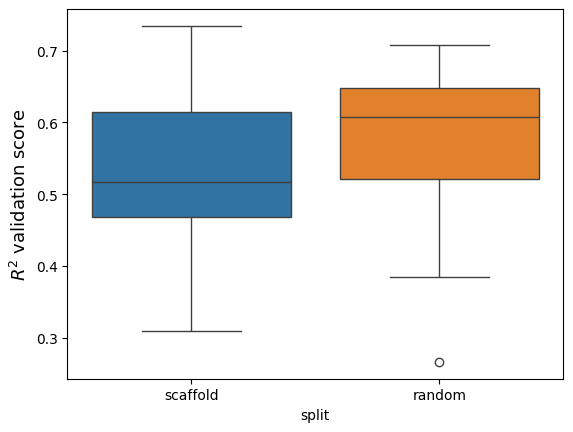

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
df_cv_compare = pd.DataFrame()

df_scaffold_cv_results = pd.DataFrame(search_scaffold.cv_results_)
df_random_cv_results =  pd.DataFrame(search_random.cv_results_)


#get the row corresponding to the best hyperparameters
scaffold_best_idx = df_scaffold_cv_results[['mean_test_score']].idxmax().values[0]
random_best_idx = df_random_cv_results[['mean_test_score']].idxmax().values[0]

#get the CV scores of the best hyperparameters
scaffold_split_cv_score = df_scaffold_cv_results.loc[scaffold_best_idx,df_scaffold_cv_results.columns.str.contains("split")]
random_split_cv_score =  df_random_cv_results.loc[random_best_idx,df_random_cv_results.columns.str.contains("split")]

#prepare dataframe for boxplot
df_cv_compare["score"] = list(scaffold_split_cv_score) + list(random_split_cv_score)
df_cv_compare["split"] = ["scaffold" for i in scaffold_split_cv_score ] + ["random" for i in random_split_cv_score ]

sns.boxplot(data=df_cv_compare, x="split", y="score",hue="split")
plt.ylabel("$R^2$ validation score",fontsize=13)
plt.show()

In [18]:
#!pip install statsmodels
from statsmodels.stats.multicomp import pairwise_tukeyhsd
thsd = pairwise_tukeyhsd(df_cv_compare.score, df_cv_compare.split)

In [19]:
print(thsd)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
random scaffold  -0.0331 0.3489 -0.1037 0.0375  False
-----------------------------------------------------


In TukeyHSD test, if **p-adj < 0.05**, there is a **statistically significant difference**. 

In real world scenario, the new compounds to be evaluated will likely contain different scaffolds from that of the training set.

Now, let's compare the model performance on unseen scaffolds, i.e. our **test set**.

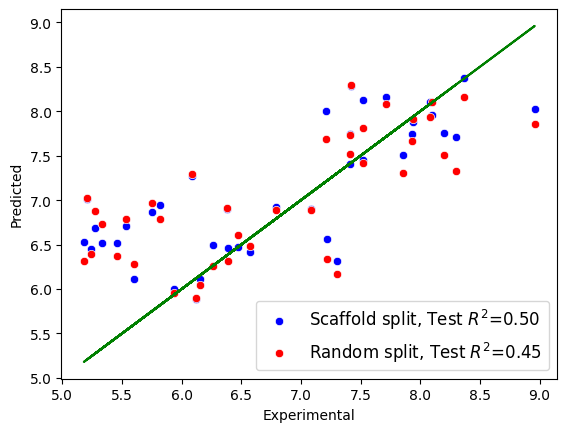

In [30]:



y_pred_random = search_random.best_estimator_.predict(X_test)
r2_random = r2_score(y_test,y_pred_random)

sns.scatterplot(x=y_test, y=y_pred_scaffold,color='b',label=f"Scaffold split, Test $R^2$={r2_scaffold:.2f}")
sns.scatterplot(x=y_test, y=y_pred_random,color='r',label=f"Random split, Test $R^2$={r2_random:.2f}")
plt.plot(y_test,y_test,color='g')

plt.xlabel("Experimental")
plt.ylabel("Predicted")
plt.legend(fontsize=12)
plt.show()

In [31]:
df_cv_test = pd.DataFrame()
df_cv_test["split type"] = ["scaffold","random"] 
df_cv_test["validation score"] = [scaffold_split_cv_score.median(),random_split_cv_score.median()]   
df_cv_test["test score"] = [r2_scaffold,r2_random]
df_cv_test

,split type,validation score,test score
0,scaffold,0.516411,0.496112
1,random,0.607743,0.452201


## Take aways

In this example, the model trained via scaffold splits tends to have better generalizability on unseen scaffolds.

Moreover, the discrepancy between the validation and test score is higher in random splits than in scaffold splits.

Based on this result, scaffold splits can potentially:
- give **a more realistic estimation of model performance than the default random splits**
- **help mitigate overfitting** during hyperparameter optimization

Although this outcome could highly depend on the data itself (as well as the arbitrary random states), this notebook shows the advantage of using scaffold splits, which has now a **convenient implementation in scikit-mol**. :)